In [8]:
import torch
import os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [9]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [10]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

In [11]:
class cnnmodel(nn.Module):
  def __init__(self):
    super().__init__()
# 1. Define the archtecture of the CNN
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size= 3, padding = 1)
    self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
    self.maxpool2 = nn.MaxPool2d(kernel_size= 2, stride = 2)

    # fullyconected layer
    self.fullyconnectedlayer = nn.Linear(in_features=64*8*8, out_features= 128)
    self.outputlayer = nn.Linear(in_features = 128, out_features = 10)

# 2. Define the forward pass by inputing the batch
  def forward(self, xb):
    out = F.relu(self.conv1(xb))
    out = self.maxpool1(out)
    out = F.relu(self.conv2(out))
    out = self.maxpool2(out)

    out = out.view(out.size(0), -1)
    out = F.relu(self.fullyconnectedlayer(out))
    out = self.outputlayer(out)

    return out
# 3. Pass the batch to the CNN architecture
  def training_step(self, batch):
    images, labels = batch
    out = self.forward(images)
    loss = F.cross_entropy(out, labels)
    _, pred = torch.max(out, dim = 1)
    acc = torch.tensor(torch.sum(pred == labels).item() / len(pred))
    return {'loss': loss, 'acc': acc}

  def training_epoch_end(self, output):
    batch_losses = [x['loss'] for x in output]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['acc'] for x in output]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(
        epoch, result['loss'], result['acc']))

In [12]:
def evaluate(model, train_loader):
  with torch.no_grad():
    outputs = [model.training_step(batch) for batch in train_loader]
  return model.training_epoch_end(outputs)

def fit(epochs, lr, model, train_loader):
  history = []
  optimizer = optim.SGD(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:

      loss_dict = model.training_step(batch)
      loss = loss_dict['loss']

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, train_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history



In [13]:
model = cnnmodel()
history = fit(120, 0.01, model, train_loader)

Epoch [0], train_loss: 2.1733, train_acc: 0.2271
Epoch [1], train_loss: 1.9660, train_acc: 0.2884
Epoch [2], train_loss: 1.8637, train_acc: 0.3383
Epoch [3], train_loss: 1.8261, train_acc: 0.3566
Epoch [4], train_loss: 1.7000, train_acc: 0.3966
Epoch [5], train_loss: 1.6028, train_acc: 0.4287
Epoch [6], train_loss: 1.5923, train_acc: 0.4320
Epoch [7], train_loss: 1.4565, train_acc: 0.4830
Epoch [8], train_loss: 1.4077, train_acc: 0.4978
Epoch [9], train_loss: 1.3847, train_acc: 0.5050
Epoch [10], train_loss: 1.3421, train_acc: 0.5218
Epoch [11], train_loss: 1.3029, train_acc: 0.5360
Epoch [12], train_loss: 1.2873, train_acc: 0.5388
Epoch [13], train_loss: 1.2524, train_acc: 0.5573
Epoch [14], train_loss: 1.2501, train_acc: 0.5525
Epoch [15], train_loss: 1.2571, train_acc: 0.5590
Epoch [16], train_loss: 1.1865, train_acc: 0.5792
Epoch [17], train_loss: 1.1861, train_acc: 0.5764
Epoch [18], train_loss: 1.1461, train_acc: 0.5982
Epoch [19], train_loss: 1.1180, train_acc: 0.6095
Epoch [20]

In [14]:
#Saving the model weight 

torch.save(model.state_dict(),'cnnmodel_weight.pth')

# Testing Phase

Shape: torch.Size([3, 32, 32])
Label: 3


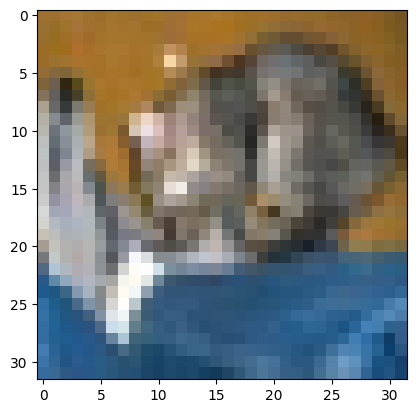

In [23]:


import matplotlib.pyplot as plt

image, label = test_dataset[0]
plt.imshow(image.permute(1,2,0))
print('Shape:', image.shape)
print('Label:', label )

In [25]:
image.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

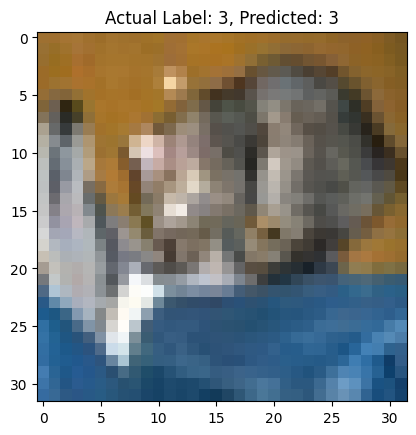

Label: 3 Prediction: 3


In [30]:
# Define the predict function
def predict_image(image, model):
    # Add a batch dimension (unsqueeze) to the image
    img = image.unsqueeze(0)
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Disable gradient calculation
    with torch.no_grad():
        # Get the model's prediction
        prediction = model(img)
        _, pred = torch.max(prediction, dim=1)
        
    return pred[0].item()

# Display the first test image
image, label = test_dataset[0]
plt.imshow(image.permute(1, 2, 0))  # Convert from CHW to HWC for visualization
plt.title(f'Actual Label: {label}, Predicted: {predict_image(image, model)}')
plt.show()

print('Label:', label, 'Prediction:', predict_image(image, model))
